In [72]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu

import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

import networkx as nx
from matplotlib.lines import Line2D
import math


# Loading Raw Data

In [73]:
ia_Q_path = "full/ia_Q.csv"
ia_A_path = "full/ia_A.csv"
ia_QA_path = "full/ia_QA.csv"

In [74]:
#df_Q = pd.read_csv(ia_Q_path)
df_A = pd.read_csv(ia_A_path)
#df_QA = pd.read_csv(ia_QA_path)

# Selecting Relevant and Separating Reading Regimes

In [75]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

# Generating Basic By Row Features

In [76]:
def create_correct_answer(df):
    df = df.copy()
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df

In [77]:
def create_answers_texts(df):
    df = df.copy()
    def get_answer_by_char(row, char):
        answer_idx = eval(row["answers_order"]).index(char)
        return row[f"answer_{answer_idx + 1}"]

    df["answer_A"] = df.apply(
        lambda row: get_answer_by_char(row, "A"), axis=1
    )
    df["answer_B"] = df.apply(
        lambda row: get_answer_by_char(row, "B"), axis=1
    )
    df["answer_C"] = df.apply(
        lambda row: get_answer_by_char(row, "C"), axis=1
    )
    df["answer_D"] = df.apply(
        lambda row: get_answer_by_char(row, "D"), axis=1
    )
    return df

In [78]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [79]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [80]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [81]:
def created_selected_area_bool(df):
    area_mapping = {
    'A': 'answer_A',
    'B': 'answer_B',
    'C': 'answer_C',
    'D': 'answer_D'
    }

    df['selected_area'] = df['selected_answer_label'].map(area_mapping)
    df['is_selected_area'] = df['area_label'] == df['selected_area']
    return df

In [82]:
def filter_fixation_sequence_by_ia_id(df):
    df_new = df.copy()

    def filter_group(group):
        valid_ids = set(group['IA_ID'].dropna().unique())
        group = group.copy()
        group['INTEREST_AREA_FIXATION_SEQUENCE_clean'] = group['INTEREST_AREA_FIXATION_SEQUENCE'].apply(
            lambda seq: [x for x in seq if x in valid_ids] if isinstance(seq, list) else seq
        )
        return group

    df_new = df_new.groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(filter_group)
    return df_new

In [83]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_correct_answer,
    create_answers_texts,
    create_area_screen_loc,
    create_area_label,

    create_selected_answer_label,
    created_selected_area_bool,
    filter_fixation_sequence_by_ia_id
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_correct_answer at 0x0000022C9B5F2560>
<function create_answers_texts at 0x0000022C9B5F25F0>
<function create_area_screen_loc at 0x0000022D49896D40>
<function create_area_label at 0x0000022C9B5F2170>
<function create_selected_answer_label at 0x0000022CB3189E10>
<function created_selected_area_bool at 0x0000022CE794B370>
<function filter_fixation_sequence_by_ia_id at 0x0000022D49865630>
<function create_correct_answer at 0x0000022C9B5F2560>
<function create_answers_texts at 0x0000022C9B5F25F0>
<function create_area_screen_loc at 0x0000022D49896D40>
<function create_area_label at 0x0000022C9B5F2170>
<function create_selected_answer_label at 0x0000022CB3189E10>
<function created_selected_area_bool at 0x0000022CE794B370>
<function filter_fixation_sequence_by_ia_id at 0x0000022D49865630>


# Specialised Groupings Features Generators

In [84]:
def create_mean_area_dwell_time(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [85]:
def create_mean_area_fix_count(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_fixations_count=("IA_FIXATION_COUNT", "mean"))

In [86]:
def create_mean_first_fix_duration(df):
    df['IA_FIRST_FIXATION_DURATION_INT'] = df["IA_FIRST_FIXATION_DURATION"].replace('.', 0).astype(int)
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_first_fixation_duration=("IA_FIRST_FIXATION_DURATION_INT", "mean"))

In [87]:
def create_skip_rate(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(skip_rate=("IA_SKIP", "mean"))

In [88]:
def create_dwell_proportions(df):
    aggregated_df = (
        df.groupby(['participant_id', 'TRIAL_INDEX', 'area_label'], as_index=False)
        .agg({'IA_DWELL_TIME': 'sum'})
        .rename(columns={'IA_DWELL_TIME': 'total_area_dwell_time'})
    )

    aggregated_df['total_dwell_time'] = aggregated_df.groupby(['participant_id', 'TRIAL_INDEX'])['total_area_dwell_time'].transform('sum')

    aggregated_df['area_dwell_proportion'] = aggregated_df['total_area_dwell_time'] / aggregated_df['total_dwell_time']
    aggregated_df = aggregated_df.fillna(0)

    return aggregated_df

In [89]:
def create_last_area_and_location_visited(df):
    df['IA_LAST_FIXATION_TIME_INT'] = df["IA_LAST_FIXATION_TIME"].replace('.', 0).astype(int)
    df_sorted = df.sort_values(by=['participant_id', 'TRIAL_INDEX', 'IA_LAST_FIXATION_TIME_INT'], ascending=[True, True, False])
    top_fixations = df_sorted.groupby(['participant_id', 'TRIAL_INDEX']).head(5)

    last_area = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_label']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_label': 'last_area_visited'})
    )

    last_location = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_screen_loc']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_screen_loc': 'last_location_visited'})
    )

    result = pd.merge(last_area, last_location, on=['participant_id', 'TRIAL_INDEX'])

    return result

In [90]:
def create_fixation_sequence_tags(df):
    ia_id_to_label = dict(zip(df['IA_ID'], df['area_label']))
    ia_id_to_location = dict(zip(df['IA_ID'], df['area_screen_loc']))

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)
        label_sequence = [ia_id_to_label.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        location_sequence = [ia_id_to_location.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': label_sequence,
            'fix_by_loc': location_sequence
        })

    return pd.DataFrame(result)



# Feature Generation

In [91]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [92]:
per_row_feature_generators = [
    (create_mean_area_dwell_time, {}),
    (create_mean_area_fix_count, {}),
    (create_mean_first_fix_duration, {}),
    (create_skip_rate, {}),
    (create_dwell_proportions, {}),
    (create_last_area_and_location_visited, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']})
]

In [93]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_mean_area_dwell_time at 0x0000022B0C57B910>
<function create_mean_area_fix_count at 0x0000022B0C57A680>
<function create_mean_first_fix_duration at 0x0000022B0C57AEF0>
<function create_skip_rate at 0x0000022B0C57B880>
<function create_dwell_proportions at 0x0000022B0C57AC20>
<function create_last_area_and_location_visited at 0x0000022B0C57A0E0>
<function create_fixation_sequence_tags at 0x0000022B0C57B7F0>
<function create_mean_area_dwell_time at 0x0000022B0C57B910>
<function create_mean_area_fix_count at 0x0000022B0C57A680>
<function create_mean_first_fix_duration at 0x0000022B0C57AEF0>
<function create_skip_rate at 0x0000022B0C57B880>
<function create_dwell_proportions at 0x0000022B0C57AC20>
<function create_last_area_and_location_visited at 0x0000022B0C57A0E0>
<function create_fixation_sequence_tags at 0x0000022B0C57B7F0>


In [94]:
df_with_features_h[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area', 'correct_answer_position',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,correct_answer_position,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,4,l42_2070,What,question,question,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_A,answer_3,"[question, question, question, question, quest...","[question, question, question, question, quest..."
1,4,l42_2070,is,question,question,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_A,answer_3,"[question, question, question, question, quest...","[question, question, question, question, quest..."
2,4,l42_2070,Currie,question,question,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_A,answer_3,"[question, question, question, question, quest...","[question, question, question, question, quest..."
3,4,l42_2070,Technologies?,question,question,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_A,answer_3,"[question, question, question, question, quest...","[question, question, question, question, quest..."
4,4,l42_2070,A,answer_B,answer_0,A,answer_A,False,3,173.000000,1.000000,94.285714,0.571429,0.213167,answer_A,answer_3,"[question, question, question, question, quest...","[question, question, question, question, quest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380345,59,l10_39,the,answer_B,answer_3,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_B,answer_3,"[out_of_bounds, answer_D, answer_D, out_of_bou...","[out_of_bounds, answer_0, answer_0, out_of_bou..."
380346,59,l10_39,head,answer_B,answer_3,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_B,answer_3,"[out_of_bounds, answer_D, answer_D, out_of_bou...","[out_of_bounds, answer_0, answer_0, out_of_bou..."
380347,59,l10_39,of,answer_B,answer_3,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_B,answer_3,"[out_of_bounds, answer_D, answer_D, out_of_bou...","[out_of_bounds, answer_0, answer_0, out_of_bou..."
380348,59,l10_39,the,answer_B,answer_3,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_B,answer_3,"[out_of_bounds, answer_D, answer_D, out_of_bou...","[out_of_bounds, answer_0, answer_0, out_of_bou..."


In [95]:
df_with_features_g[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,3,l59_485,What,question,question,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_D,answer_2,"[question, out_of_bounds, question, answer_B, ...","[question, out_of_bounds, question, answer_0, ..."
1,3,l59_485,is,question,question,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_D,answer_2,"[question, out_of_bounds, question, answer_B, ...","[question, out_of_bounds, question, answer_0, ..."
2,3,l59_485,opposite,question,question,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_D,answer_2,"[question, out_of_bounds, question, answer_B, ...","[question, out_of_bounds, question, answer_0, ..."
3,3,l59_485,Cockrell's,question,question,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_D,answer_2,"[question, out_of_bounds, question, answer_B, ...","[question, out_of_bounds, question, answer_0, ..."
4,3,l59_485,office?,question,question,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_D,answer_2,"[question, out_of_bounds, question, answer_B, ...","[question, out_of_bounds, question, answer_0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380273,65,l2_324,leave,answer_C,answer_3,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_A,answer_2,"[question, out_of_bounds, answer_B, answer_B, ...","[question, out_of_bounds, answer_0, answer_0, ..."
380274,65,l2_324,risky,answer_C,answer_3,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_A,answer_2,"[question, out_of_bounds, answer_B, answer_B, ...","[question, out_of_bounds, answer_0, answer_0, ..."
380275,65,l2_324,work,answer_C,answer_3,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_A,answer_2,"[question, out_of_bounds, answer_B, answer_B, ...","[question, out_of_bounds, answer_0, answer_0, ..."
380276,65,l2_324,in,answer_C,answer_3,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_A,answer_2,"[question, out_of_bounds, answer_B, answer_B, ...","[question, out_of_bounds, answer_0, answer_0, ..."


# Visualisations

### Boxplots and U-Tests

In [96]:
def plot_boxplot(dataframe, x_column, y_column, hue_column, plt_title="Boxplot"):
    dataframe = dataframe[['TRIAL_INDEX','participant_id', x_column, y_column, hue_column]].drop_duplicates().copy()
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=dataframe,
        x=x_column,
        y=y_column,
        hue=hue_column,
        showfliers=False
    )
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(title=hue_column)
    plt.show()


In [97]:
# text_id = article_id + difficulty_level + paragraph_id + article_batch

In [98]:
def analyze_metric_stat_mixed(dataframe,
                              label_column,
                              stat_column,
                              correct_column='is_correct',
                              article_col='article_id',
                              difficulty_col='difficulty_level',
                              batch_col='article_batch',
                              paragraph_col='paragraph_id',
                              participant_col='participant_id'):


    dataframe = dataframe[['TRIAL_INDEX', participant_col, label_column, stat_column, correct_column,
                           article_col,difficulty_col,batch_col,paragraph_col ]].drop_duplicates().copy()
    dataframe['text_id'] = dataframe.apply(
        lambda row: f"{row[article_col]}_{row[difficulty_col]}_{row[batch_col]}_{row[paragraph_col]}",
        axis=1
    )

    categories = dataframe[label_column].unique()
    results = []

    valid_participants = (
        dataframe.groupby(participant_col)[correct_column]
                 .nunique()
                 .pipe(lambda s: s[s == 2].index)
    )
    df_filtered = dataframe[dataframe[participant_col].isin(valid_participants)]

    for category in categories:
        category_data = df_filtered[df_filtered[label_column] == category].copy()

        correct_data = category_data[category_data[correct_column] == 1]
        incorrect_data = category_data[category_data[correct_column] == 0]

        if len(correct_data) == 0 or len(incorrect_data) == 0:
            continue

        median_correct = correct_data[stat_column].median()
        median_incorrect = incorrect_data[stat_column].median()
        mean_correct = correct_data[stat_column].mean()
        mean_incorrect = incorrect_data[stat_column].mean()

        formula = f"{stat_column} ~ {correct_column}"

        model = smf.mixedlm(
            formula,
            data=category_data,
            groups=category_data[participant_col],
            re_formula="~1",
            vc_formula={"text_id": "0 + C(text_id)"}
        )
        fit_result = model.fit()
        param_name = correct_column

        if param_name in fit_result.params.index:
            coef = fit_result.params[param_name]
            pval = fit_result.pvalues[param_name]
        else:
            coef = np.nan
            pval = np.nan

        results.append({
            label_column: category,
            "coef_correct": coef,
            "p_value_correct": pval,
            "median_correct": median_correct,
            "median_incorrect": median_incorrect,
            "mean_correct": mean_correct,
            "mean_incorrect": mean_incorrect
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="p_value_correct")
    return results_df


In [99]:
def metric_analysis(metric):
    print("HUNTERS BOXPLOTS:")
    plot_boxplot(df_with_features_h, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (hunters)')
    plot_boxplot(df_with_features_h, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (hunters)')

    print("GATHERERS BOXPLOTS:")
    plot_boxplot(df_with_features_g, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (gatherers)')
    plot_boxplot(df_with_features_g, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (gatherers)')

    print("HUNTERS TESTS:")
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_h,
        label_column='area_label',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_h,
        label_column='area_screen_loc',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print("GATHERERS TESTS:")
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_g,
        label_column='area_label',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_g,
        label_column='area_screen_loc',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))


HUNTERS BOXPLOTS:


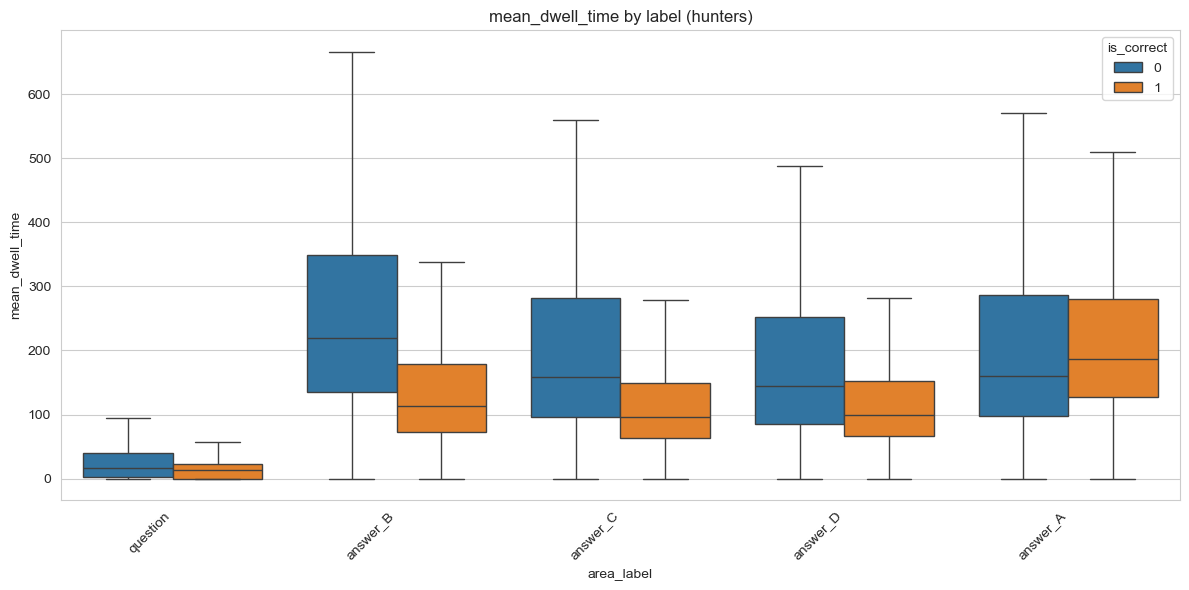

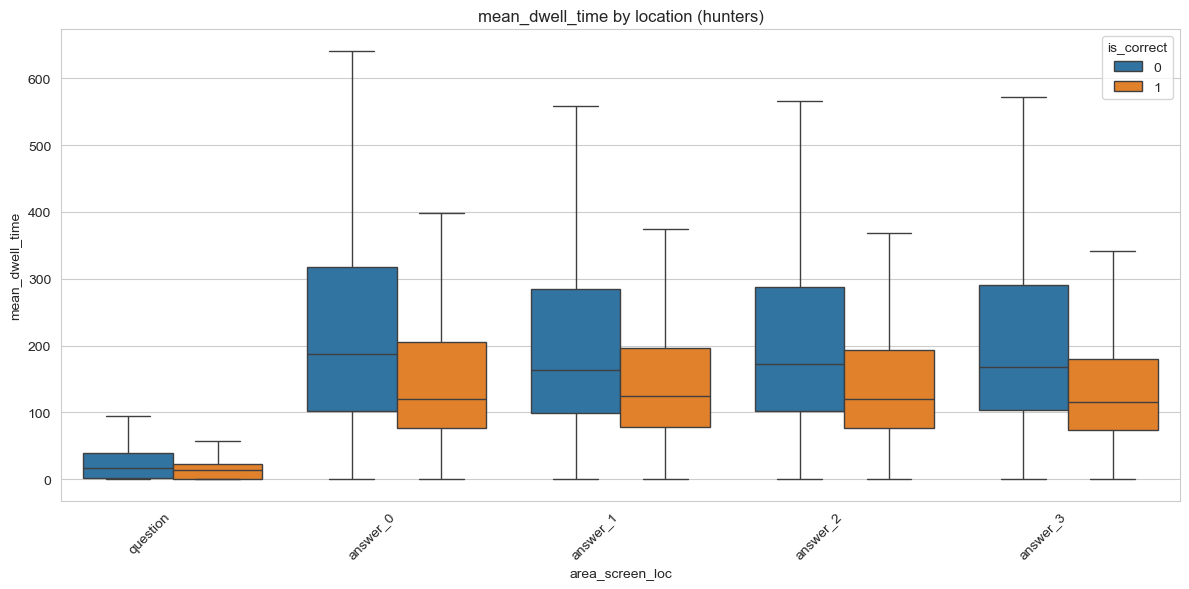

GATHERERS BOXPLOTS:


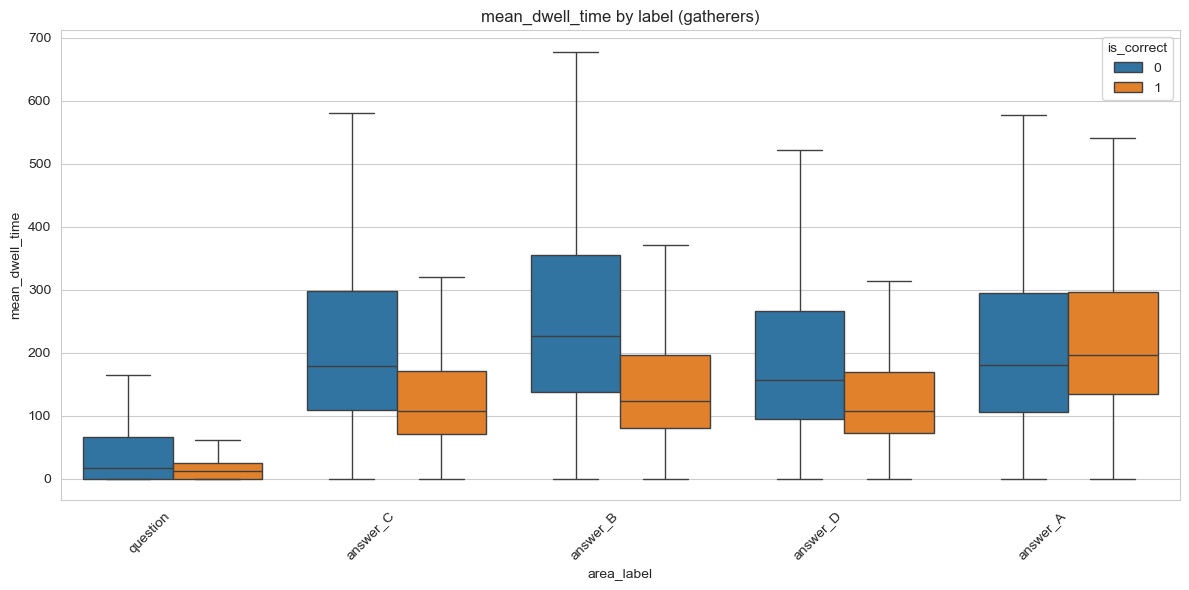

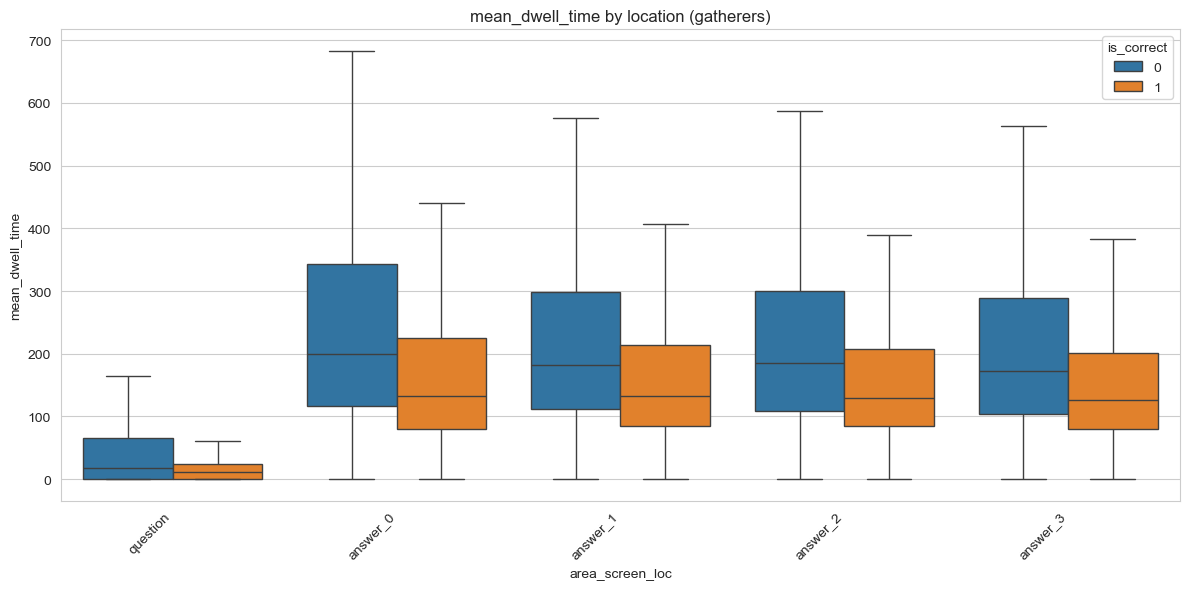

HUNTERS TESTS:


KeyboardInterrupt: 

In [100]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")

metric_analysis('mean_dwell_time')
# metric_analysis('mean_fixations_count')
# metric_analysis('mean_first_fixation_duration')
# metric_analysis('skip_rate')
# metric_analysis('area_dwell_proportion')

In [101]:
def analyze_group_differences(dataframe, label_column, stat_column, correct_column='is_correct'):
    results = []

    for is_correct_value in dataframe[correct_column].unique():
        subset_df = dataframe[dataframe[correct_column] == is_correct_value]
        categories = subset_df[label_column].unique()

        for cat1, cat2 in combinations(categories, 2):
            group1 = subset_df[subset_df[label_column] == cat1][stat_column]
            group2 = subset_df[subset_df[label_column] == cat2][stat_column]

            if len(group1) == 0 or len(group2) == 0:
                continue

            mannwhitney_result = mannwhitneyu(group1, group2, alternative='two-sided')

            results.append({
                'is_correct': is_correct_value,
                'group1': cat1,
                'group2': cat2,
                'U_statistic': mannwhitney_result.statistic,
                'p_value': mannwhitney_result.pvalue,
                'median_group1': group1.median(),
                'median_group2': group2.median(),
                'mean_group1': group1.mean(),
                'mean_group2': group2.mean()
            })

    results_df = pd.DataFrame(results)
    return results_df.sort_values(['is_correct', 'p_value'])

In [96]:
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_dwell_time')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_dwell_time')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_fixations_count')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_fixations_count')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_first_fixation_duration')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_first_fixation_duration')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='skip_rate')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='skip_rate')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='area_dwell_proportion')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='area_dwell_proportion')

,is_correct,group1,group2,U_statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
10,0,question,answer_A,9.898414e+07,0.000000e+00,0.923077,0.666667,0.928439,0.665463
12,0,question,answer_C,8.104447e+07,0.000000e+00,0.923077,0.700000,0.928439,0.718914
13,0,question,answer_D,1.087367e+08,0.000000e+00,0.923077,0.583333,0.928439,0.591664
14,0,answer_A,answer_B,2.296332e+07,0.000000e+00,0.666667,1.000000,0.665463,0.835954
18,0,answer_B,answer_D,6.789977e+07,0.000000e+00,1.000000,0.583333,0.835954,0.591664
19,0,answer_C,answer_D,5.446856e+07,1.854651e-292,0.700000,0.583333,0.718914,0.591664
17,0,answer_B,answer_C,5.430544e+07,2.110989e-261,1.000000,0.700000,0.835954,0.718914
16,0,answer_A,answer_D,5.051872e+07,9.611253e-142,0.666667,0.583333,0.665463,0.591664
15,0,answer_A,answer_C,3.596367e+07,1.701567e-59,0.666667,0.700000,0.665463,0.718914
11,0,question,answer_B,5.966125e+07,1.171536e-06,0.923077,1.000000,0.928439,0.835954


### Matrix Plots

In [102]:
def matrix_plot(df, stat, correct = 1):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    ax = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )
    if correct == 1:
        plt.title(f"{stat} of correct answers")
    else:
        plt.title(f"{stat} of incorrect answers")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    plt.show()


In [103]:
def matrix_plot_ABCD(df, stat, selected = 'A'):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    ax = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )

    plt.title(f"{stat} of those who chose {selected} ")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    plt.show()

In [104]:
def label_vs_loc_mat(metric):
    print("HUNTERS")
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'A'], metric, selected='A')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'B'], metric, selected='B')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'C'], metric, selected='C')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'D'], metric, selected='D')

    print("GATHERERS")
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'A'], metric, selected='A')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'B'], metric, selected='B')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'C'], metric, selected='C')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'D'], metric, selected='D')

HUNTERS


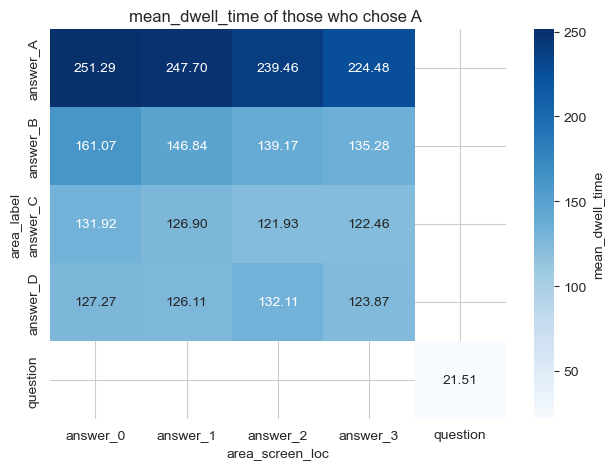

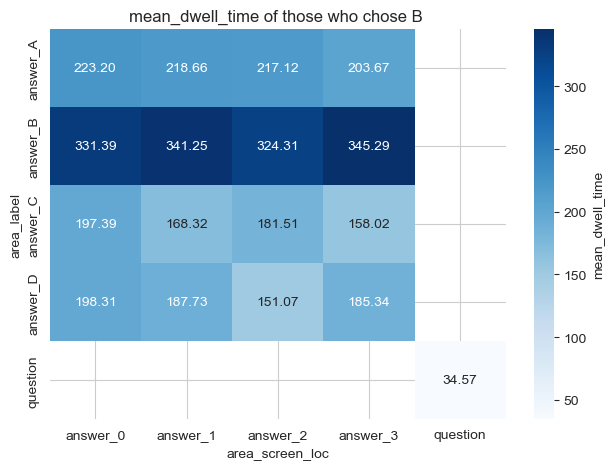

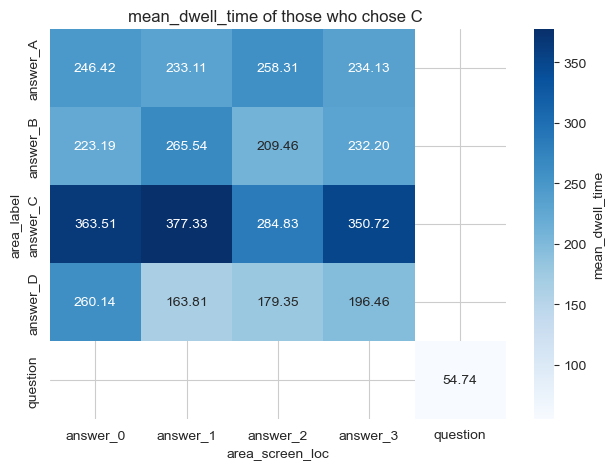

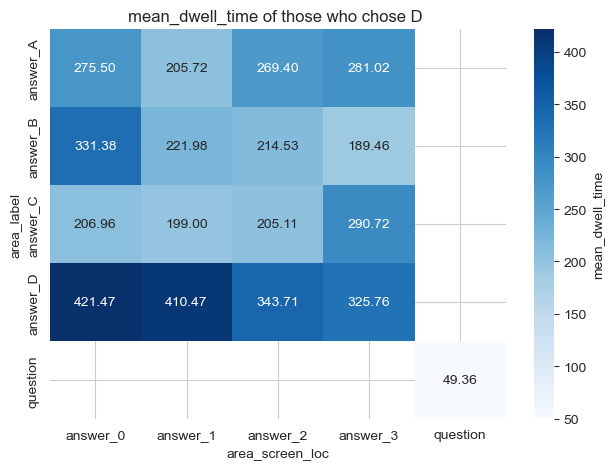

GATHERERS


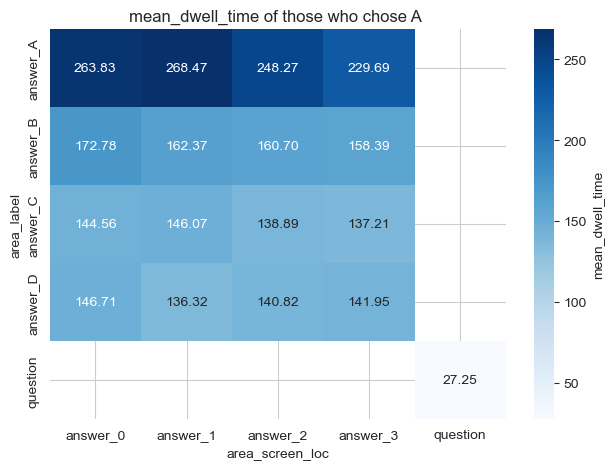

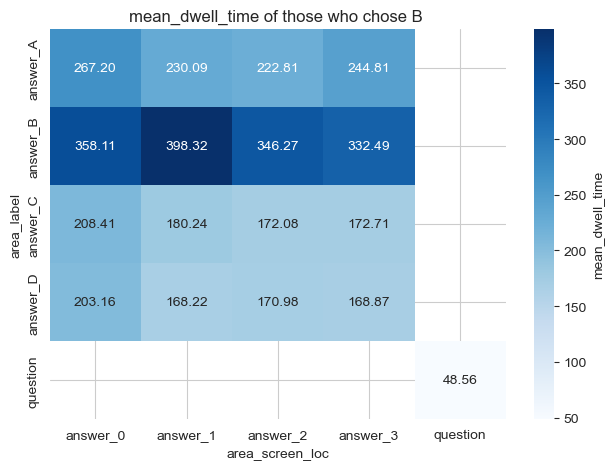

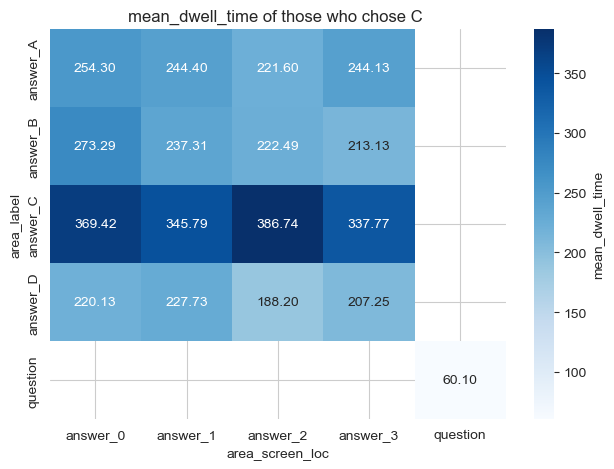

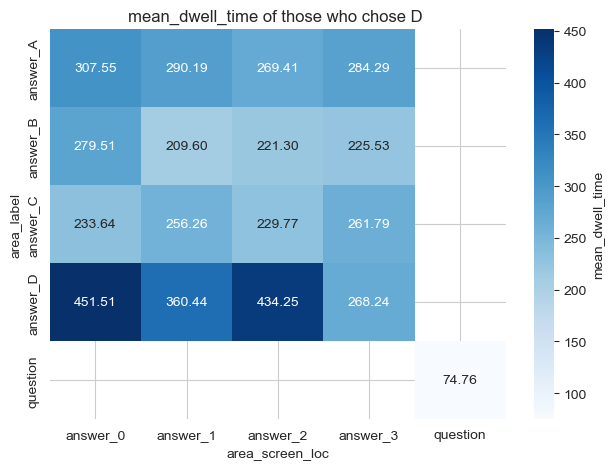

In [105]:
label_vs_loc_mat('mean_dwell_time')
# label_vs_loc_mat('mean_fixations_count')
# label_vs_loc_mat('mean_first_fixation_duration')
# label_vs_loc_mat('skip_rate')
# label_vs_loc_mat('area_dwell_proportion')



### Selected vs not selected

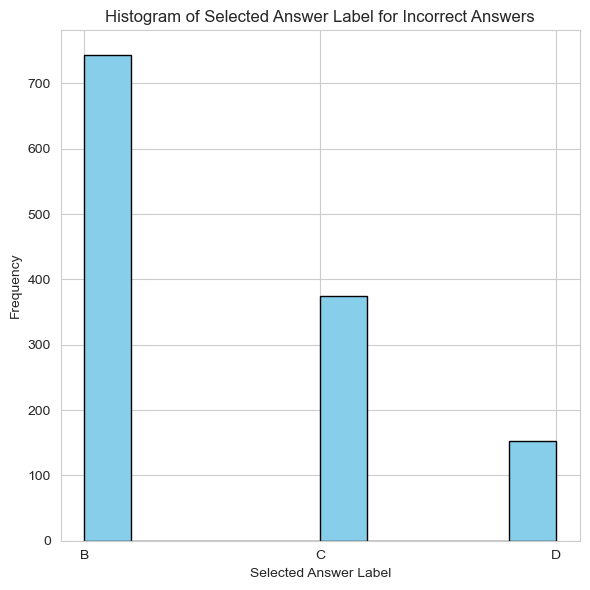

In [106]:
df = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'is_correct', 'selected_answer_label']].drop_duplicates().copy()
incorrect_answers = df[df['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_label'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Label for Incorrect Answers')
plt.xlabel('Selected Answer Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

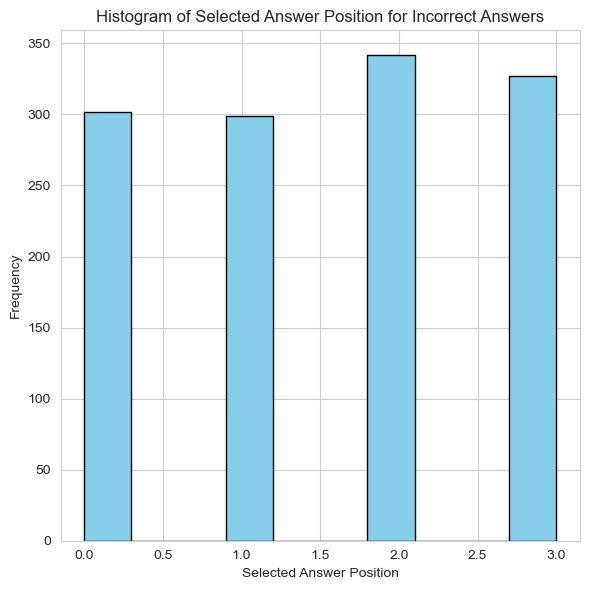

In [107]:
df = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'is_correct', 'selected_answer_position']].drop_duplicates().copy()
incorrect_answers = df[df['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_position'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Position for Incorrect Answers')
plt.xlabel('Selected Answer Position')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\deeth\AppData\Local\Temp\ipykernel_11132\4182384254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


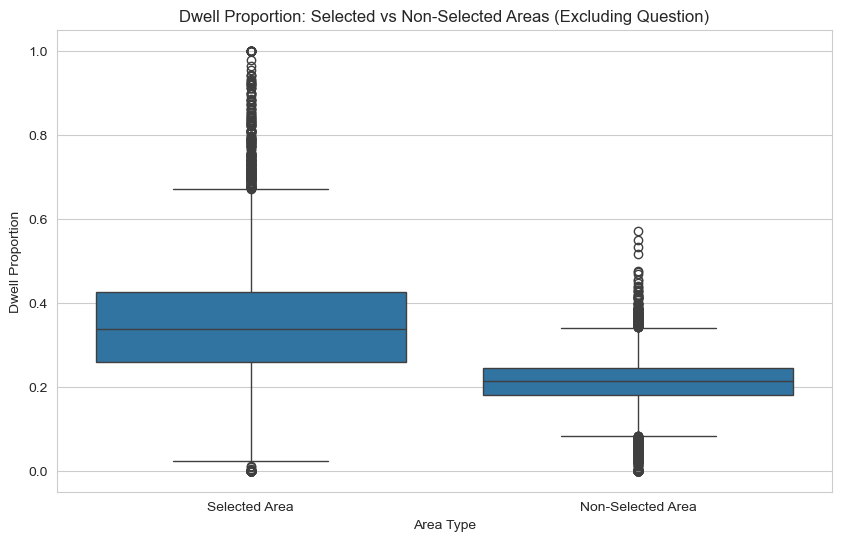

In [108]:
df_filtered = df_with_features_h[df_with_features_h['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


C:\Users\deeth\AppData\Local\Temp\ipykernel_11132\2839663135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


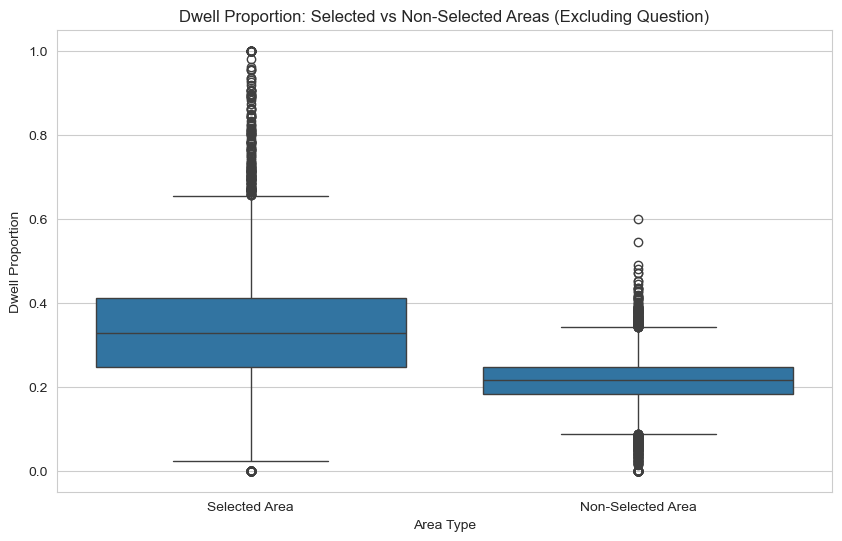

In [109]:
df_filtered = df_with_features_g[df_with_features_g['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


### Fixation Sequence Visualizations

In [110]:
df_with_features_h['fix_by_label'] = df_with_features_h['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_label'] = df_with_features_g['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_h['fix_by_loc'] = df_with_features_h['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_loc'] = df_with_features_g['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

data_rows_h = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'fix_by_label', 'fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
data_rows_g = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'fix_by_label', 'fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()


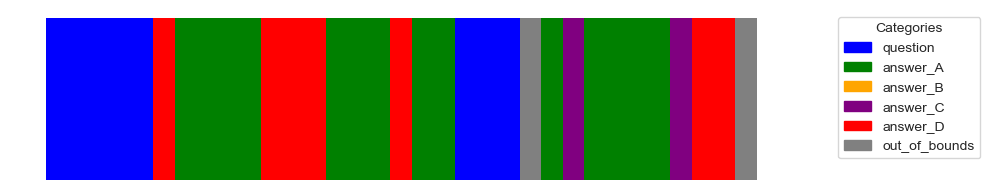

In [111]:
data_row = df_with_features_h.iloc[0]['fix_by_label']

categories = {
    "question": "blue",
    "answer_A": "green",
    "answer_B": "orange",
    "answer_C": "purple",
    "answer_D": "red",
    "out_of_bounds": "gray"
}
colors = [categories[value] for value in data_row]

plt.figure(figsize=(10, 2))
plt.bar(range(len(data_row)), [1] * len(data_row), color=colors, width=1.0, edgecolor='none')
plt.axis('off')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in categories.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

plt.tight_layout()
plt.show()

In [114]:
categories_label = {
    "question": "#74a9cf",
    "answer_A": "#238b45",
    "answer_B": "#74c476",
    "answer_C": "#bae4b3",
    "answer_D": "#edf8e9",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

categories_loc = {
    "question": "#74a9cf",
    'answer_0': "#ffffb2",
    'answer_1': "#fecc5c",
    'answer_2': "#fd8d3c",
    'answer_3': "#e31a1c",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

legend_mapping_label = {
    "question": "Question",
    "answer_A": "Answer A",
    "answer_B": "Answer B",
    "answer_C": "Answer C",
    "answer_D": "Answer D",
    "out_of_bounds": "Unclear",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

legend_mapping_loc = {
    "out_of_bounds": "Unclear",
    "question": "Question",
    "answer_0": "First A on screen",
    "answer_1": "Second A on screen",
    "answer_2": "Third A on screen",
    "answer_3": "Fourth A on screen",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}


In [115]:
def visualize_stacked_rows_with_two_labels(data_rows, categories, selected_answer_labels, additional_labels, num_rows=100, start_index=0, legend_mapping=None):
    selected_rows = data_rows[start_index:start_index + num_rows]
    selected_labels = selected_answer_labels[start_index:start_index + num_rows]
    additional_labels = additional_labels[start_index:start_index + num_rows]


    max_length = max(len(row) for row in selected_rows) + 2  # +2 to account for the labels

    color_data = []
    for row in selected_rows:
        color_row = [categories.get(value, "gray") for value in row] + ["white"] * (max_length - len(row))
        color_data.append(color_row)

    plt.figure(figsize=(15, num_rows * 0.3))
    for i, (color_row, label, additional_label) in enumerate(zip(color_data, selected_labels, additional_labels)):
        plt.bar(range(max_length), [1] * max_length, color=color_row, width=1.0, edgecolor='none', bottom=i)
        plt.text(-3.5, i + 0.5, str(additional_label), va='center', ha='right', fontsize=10, color=categories.get(additional_label, "black"))
        plt.text(-1.5, i + 0.5, str(label), va='center', ha='right', fontsize=10, color=categories.get(label, "black"))

    plt.axis('off')

    if legend_mapping:
        legend_handles = [
            mpatches.Patch(color=categories.get(original_label, "gray"), label=new_label)
            for original_label, new_label in legend_mapping.items()
            if new_label is not None
        ]
    else:
        legend_handles = [
            mpatches.Patch(color=color, label=str(label)) for label, color in categories.items()
        ]

    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    plt.tight_layout()
    plt.show()

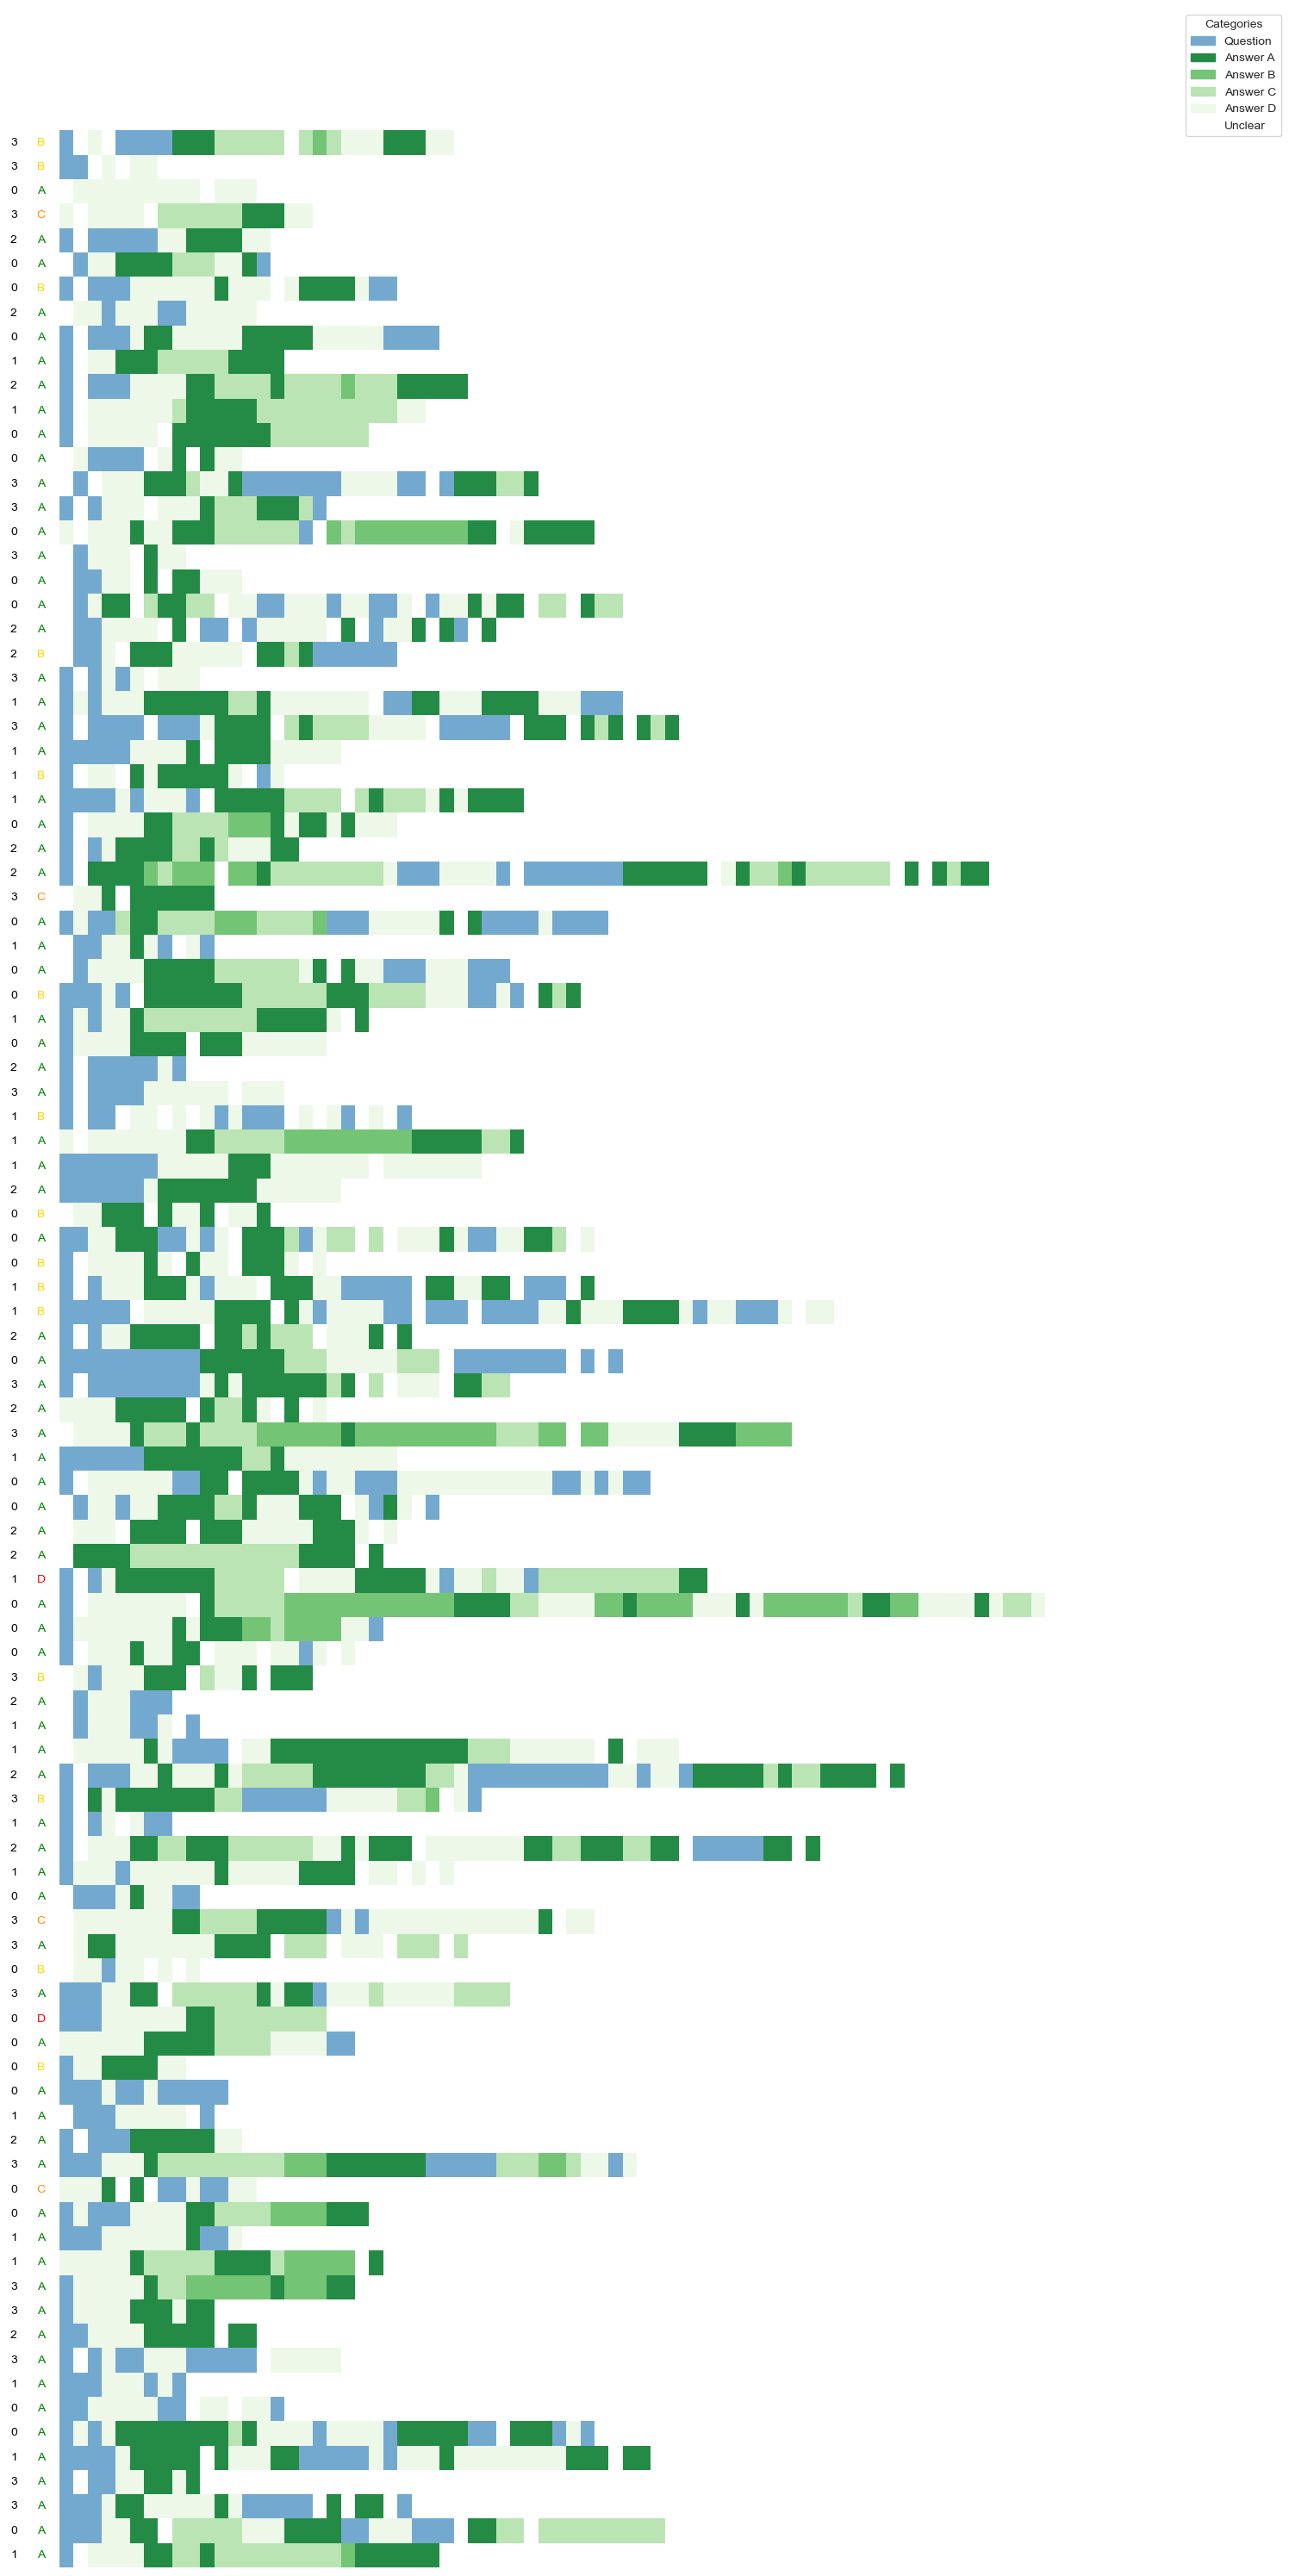

In [116]:
visualize_stacked_rows_with_two_labels(
    data_rows=data_rows_h['fix_by_label'],
    categories=categories_label,
    selected_answer_labels=data_rows_h['selected_answer_label'],
    additional_labels=data_rows_h['correct_answer_position'],
    num_rows=100,
    start_index=300,
    legend_mapping=legend_mapping_label
)

In [70]:
corr_in_zero = data_rows_h[data_rows_h['selected_answer_label'] == 'C']

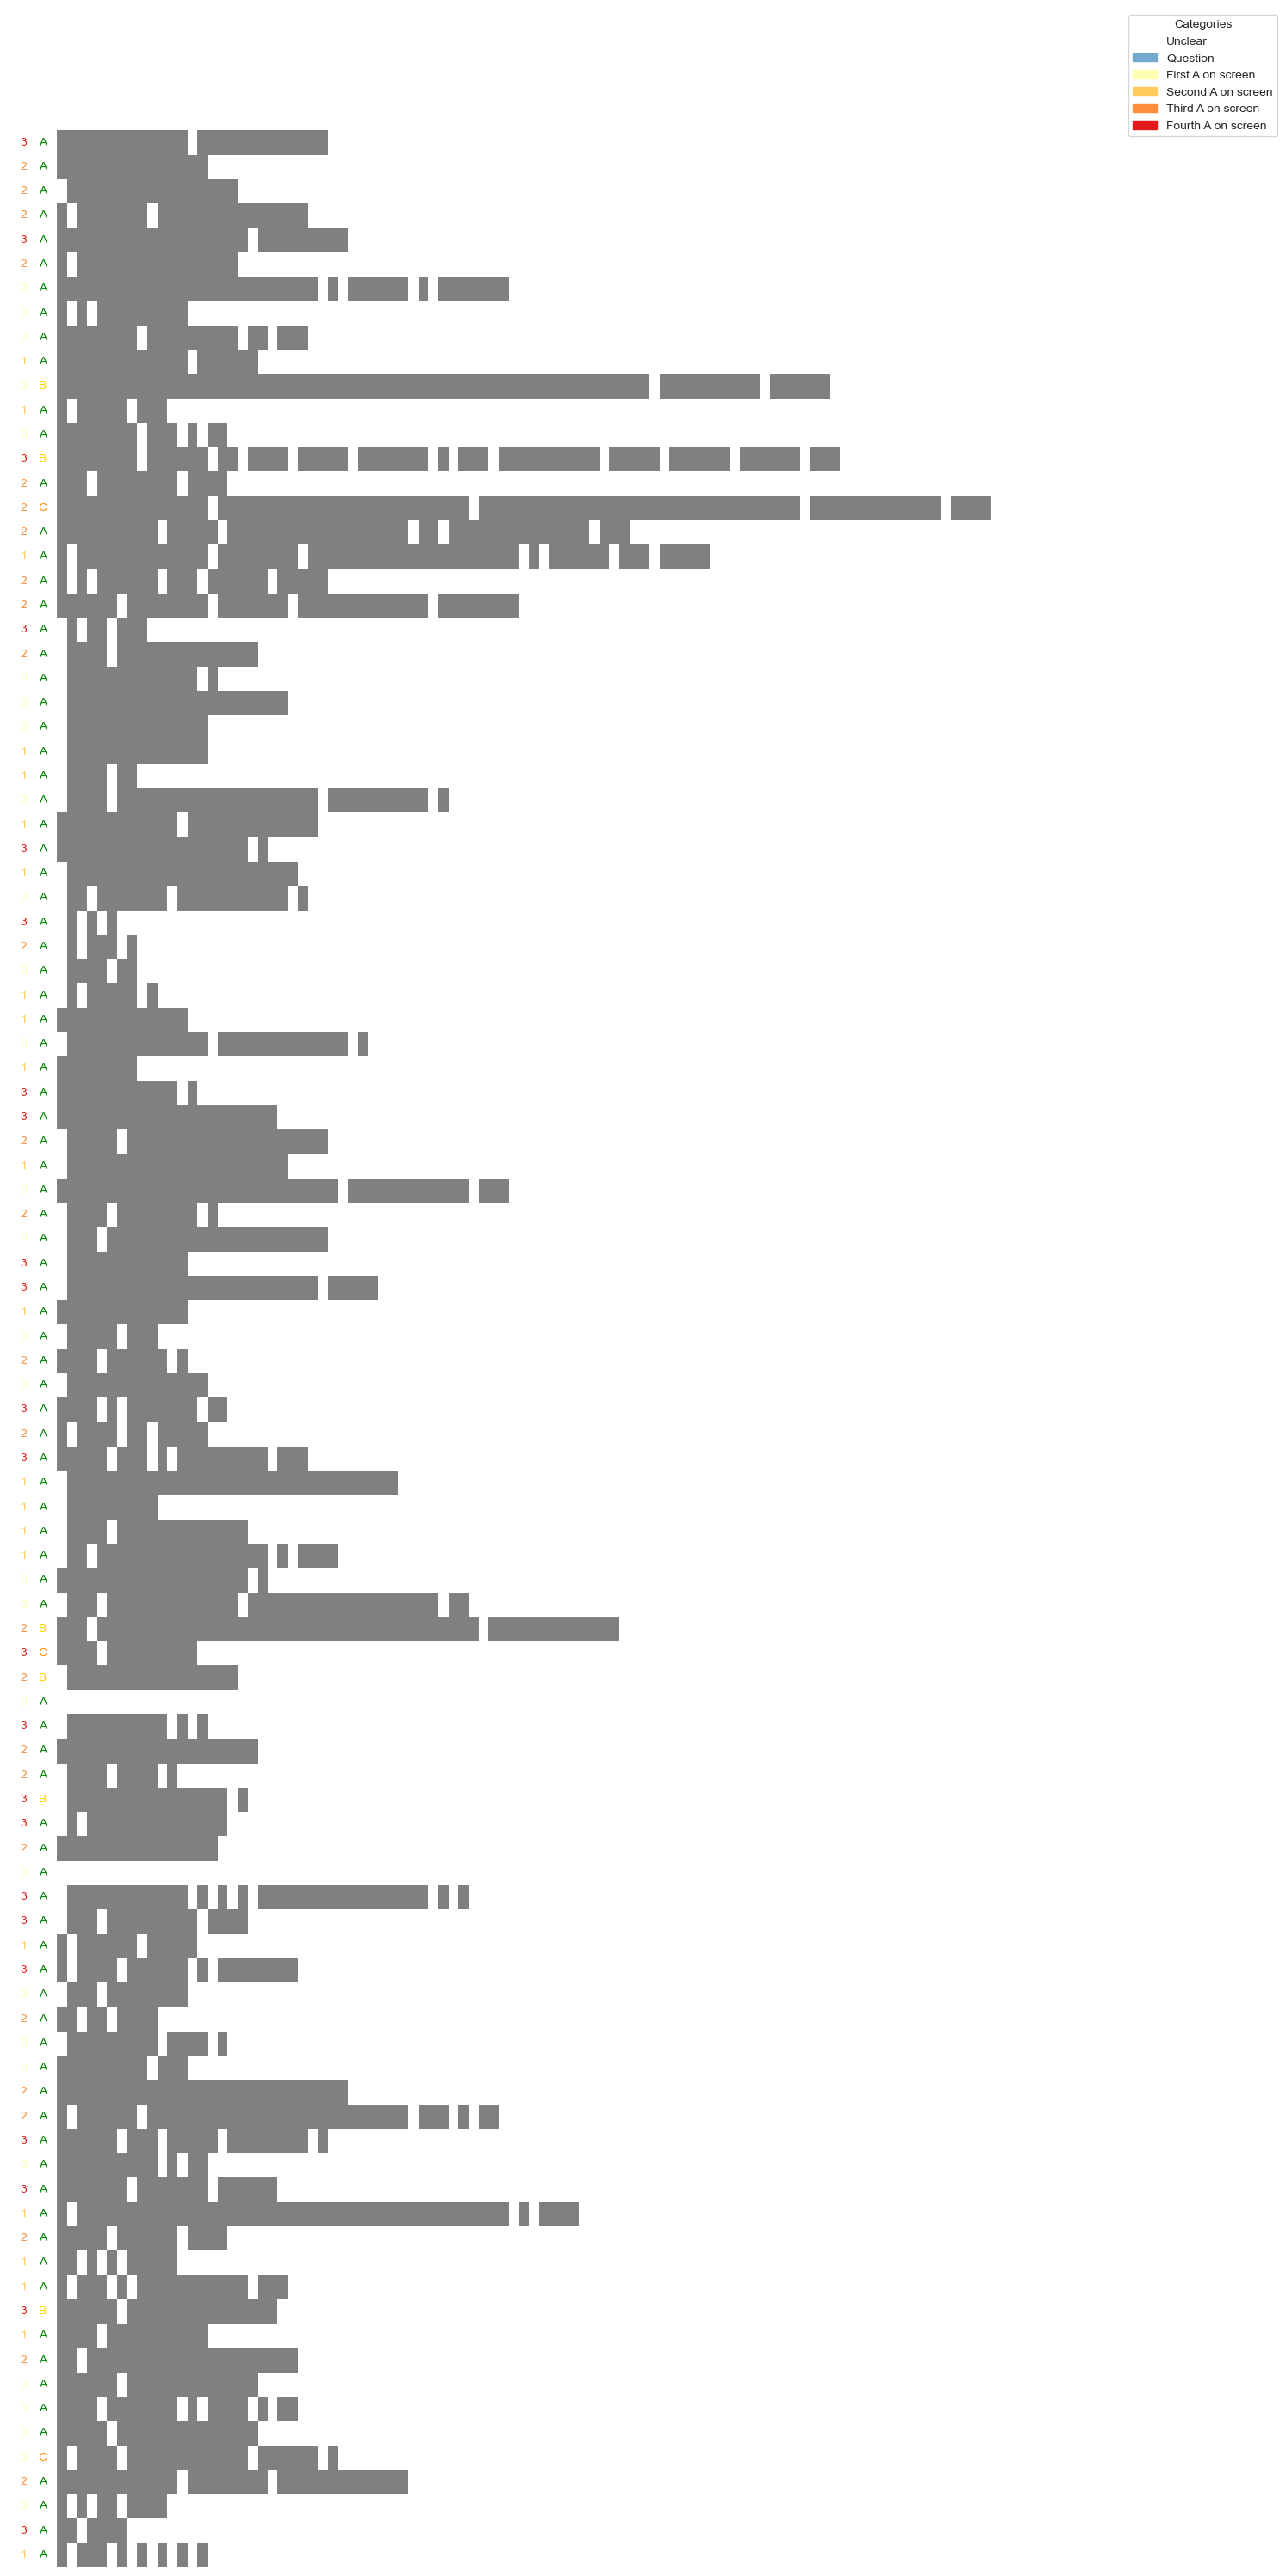

In [71]:
visualize_stacked_rows_with_two_labels(
    data_rows=data_rows_h['fix_by_loc'],
    categories=categories_loc,
    selected_answer_labels=data_rows_h['selected_answer_label'],
    additional_labels=data_rows_h['correct_answer_position'],
    num_rows=100,
    start_index=1000,
    legend_mapping=legend_mapping_loc
)

# Some sanity checks

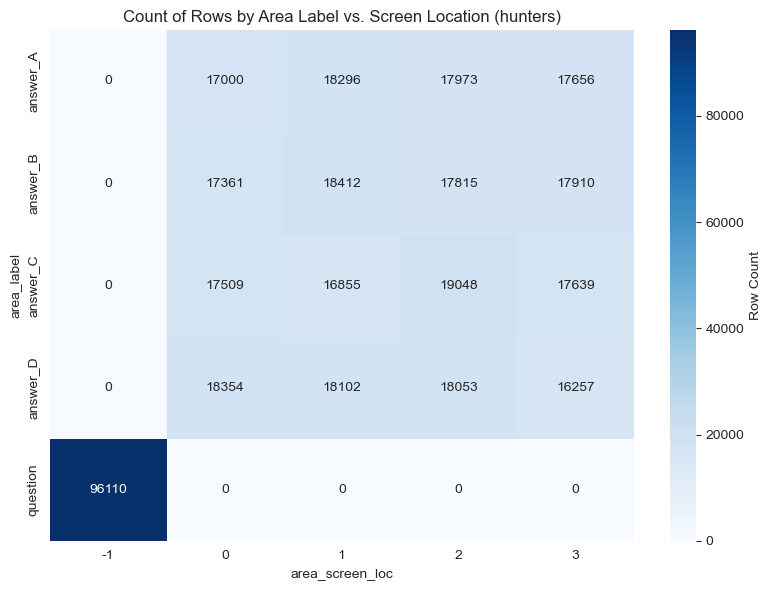

In [48]:
count_matrix = (df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

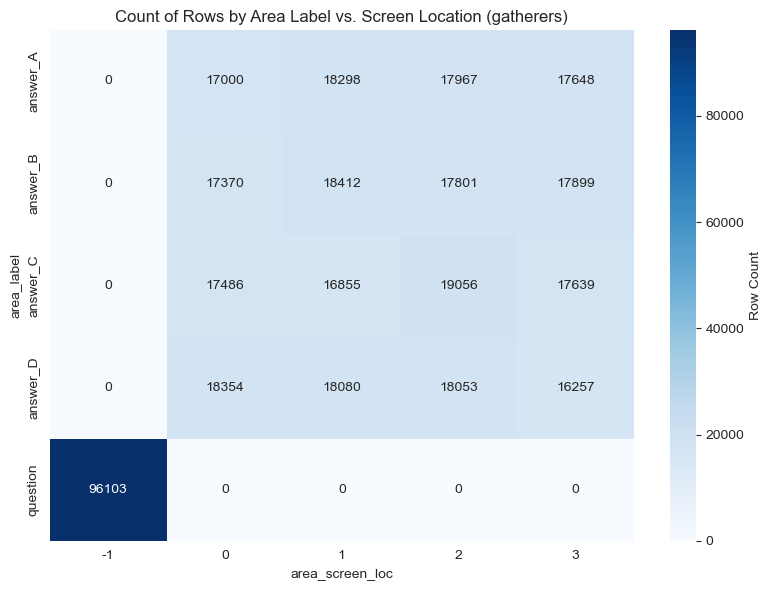

In [49]:
count_matrix = (df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

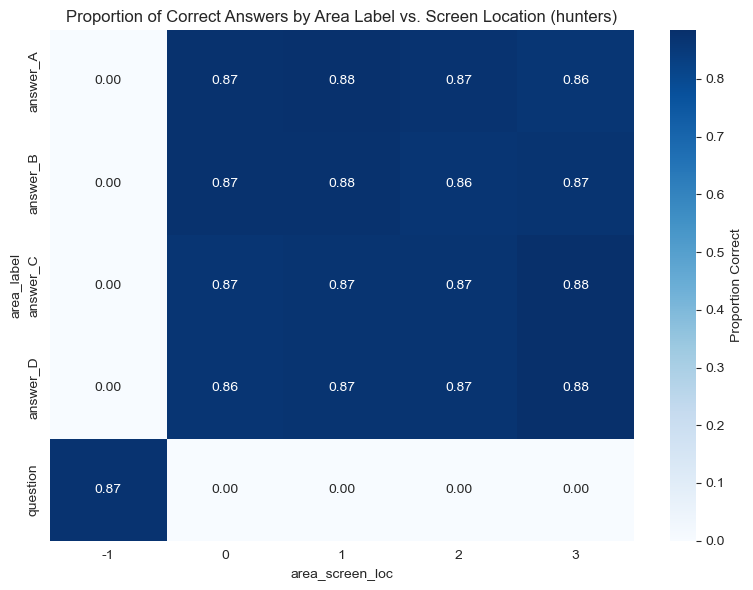

In [50]:
prop_matrix = (
    df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

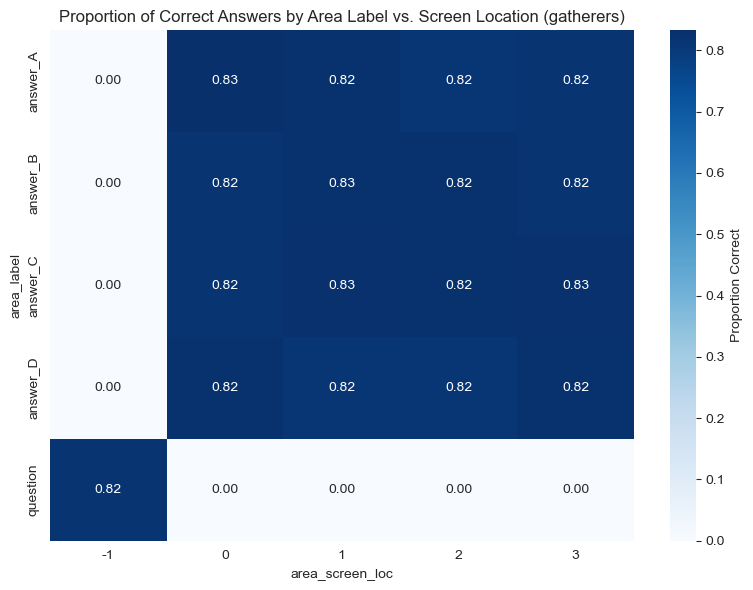

In [51]:
prop_matrix = (
    df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

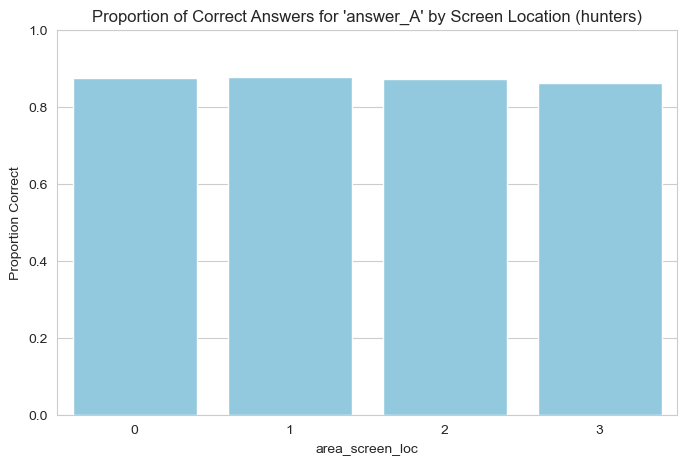

In [52]:
df_answer_A = df_with_features_h[df_with_features_h['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()

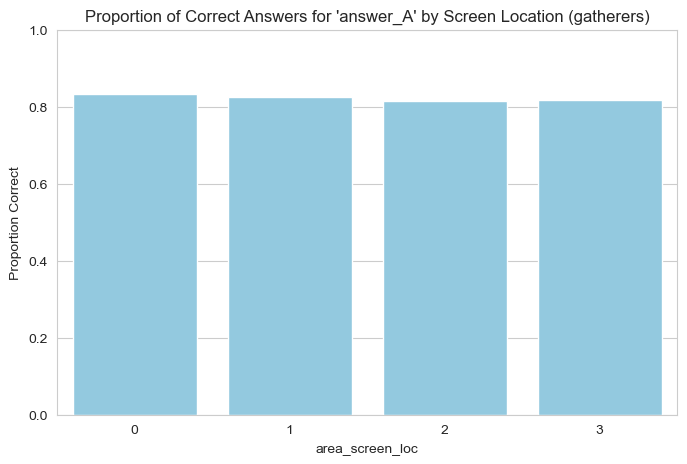

In [53]:
df_answer_A = df_with_features_g[df_with_features_g['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()

# GNN

## prep and graph building

In [150]:
 ## text_id = article_id + difficulty_level + article_batch + paragraph_id

df_h = df_with_features_h.copy()
df_h['text_id'] = df_h.apply(
        lambda row: f"{row['article_id']}_{row['difficulty_level']}_{row['article_batch']}_{row['paragraph_id']}",
        axis=1
    )

In [151]:
df_h = df_h[['TRIAL_INDEX', 'participant_id', 'text_id',
                           'IA_ID', 'IA_LABEL',

                           'IA_AREA', 'IA_BOTTOM', 'IA_RIGHT', 'IA_LEFT', 'IA_TOP',

                           'IA_AVERAGE_FIX_PUPIL_SIZE', 'IA_MAX_FIX_PUPIL_SIZE', 'IA_MIN_FIX_PUPIL_SIZE',
                           'IA_DWELL_TIME', 'IA_DWELL_TIME_%',

                           'IA_FIRST_FIXATION_DURATION', 'IA_FIRST_FIXATION_INDEX', 'IA_FIRST_FIXATION_PREVIOUS_FIX_IA',
                           'IA_FIRST_FIXATION_X', 'IA_FIRST_FIXATION_Y',
                           'IA_FIRST_FIX_PROGRESSIVE', 'IA_REGRESSION_IN_COUNT', 'IA_REGRESSION_OUT_COUNT',
                           'IA_FIRST_RUN_DWELL_TIME',
                           'IA_FIRST_SACCADE_AMPLITUDE', 'IA_FIRST_SACCADE_ANGLE',

                           'IA_FIXATION_%', 'IA_FIXATION_COUNT',

                           'IA_LAST_FIXATION_DURATION', 'IA_LAST_FIXATION_X', 'IA_LAST_FIXATION_Y',
                           'IA_LAST_SACCADE_AMPLITUDE', 'IA_LAST_SACCADE_ANGLE',

                           'IA_SKIP',

                           'INTEREST_AREA_FIXATION_SEQUENCE_clean',

                           'is_correct', 'selected_answer_position', 'correct_answer_position',
                           'area_label', 'area_screen_loc', 'selected_answer_label',
                           'answers_order',
                           'selected_area', 'is_selected_area',

                           'word_length_no_punctuation', 'wordfreq_frequency', 'subtlex_frequency', 'gpt-2_surprisal',
                           'universal_pos', 'dependency_relation', 'entity_type', 'ptb_pos',
                           'head_word_index', 'left_dependents_count', 'right_dependents_count', 'distance_to_head',

                           'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate',
                           'area_dwell_proportion','last_area_visited', 'last_location_visited',
                           'fix_by_label', 'fix_by_loc']]

In [152]:
def to_numeric(df, col, value = 0):
    df[col] = df[col].replace('.', value).astype(float)

In [153]:
columns_to_numerize = ['IA_AVERAGE_FIX_PUPIL_SIZE', 'IA_MAX_FIX_PUPIL_SIZE', 'IA_MIN_FIX_PUPIL_SIZE', 'IA_FIRST_FIXATION_DURATION',
                       'IA_FIRST_FIXATION_INDEX', 'IA_FIRST_FIXATION_PREVIOUS_FIX_IA', 'IA_FIRST_FIXATION_X', 'IA_FIRST_FIXATION_Y',
                       'IA_FIRST_RUN_DWELL_TIME', 'IA_FIRST_SACCADE_AMPLITUDE', 'IA_FIRST_SACCADE_ANGLE', 'IA_LAST_FIXATION_DURATION',
                       'IA_LAST_FIXATION_X', 'IA_LAST_FIXATION_Y', 'IA_LAST_SACCADE_AMPLITUDE', 'IA_LAST_SACCADE_ANGLE']

columns_to_numerize_not_zero = ['IA_FIRST_FIX_PROGRESSIVE', 'IA_REGRESSION_IN_COUNT','IA_REGRESSION_OUT_COUNT']

for col in columns_to_numerize:
    to_numeric(df_h, col)
for col in columns_to_numerize_not_zero:
    to_numeric(df_h, col, value=-1)

In [154]:
def one_hot_encode_columns(df, columns):
    for col in columns:
        categories = sorted(df[col].dropna().unique())
        vec_length = len(categories)
        mapping = {cat: np.eye(vec_length)[i].tolist() for i, cat in enumerate(categories)}
        df[col + '_encoded'] = df[col].apply(lambda x: mapping.get(x, [0.0]*vec_length))
    return df

In [155]:
cols_to_one_hot = ['universal_pos', 'dependency_relation', 'entity_type', 'ptb_pos']
one_hot_encode_columns(df_h, cols_to_one_hot)

,TRIAL_INDEX,participant_id,text_id,IA_ID,IA_LABEL,IA_AREA,IA_BOTTOM,IA_RIGHT,IA_LEFT,IA_TOP,...,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc,universal_pos_encoded,dependency_relation_encoded,entity_type_encoded,ptb_pos_encoded
0,4,l42_2070,6_Ele_3_1,1,What,10165.0,261,453,358,154,...,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0]"
1,4,l42_2070,6_Ele_3_1,2,is,6099.0,261,510,453,154,...,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0]"
2,4,l42_2070,6_Ele_3_1,3,Currie,14231.0,261,643,510,154,...,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0]"
3,4,l42_2070,6_Ele_3_1,4,Technologies?,28569.0,261,910,643,154,...,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0]"
4,4,l42_2070,6_Ele_3_1,5,A,4180.0,492,1015,977,382,...,0.571429,0.213167,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380345,59,l10_39,5_Adv_1_5,53,the,8208.0,1281,1186,1110,1173,...,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0]"
380346,59,l10_39,5_Adv_1_5,54,head,10260.0,1281,1281,1186,1173,...,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0]"
380347,59,l10_39,5_Adv_1_5,55,of,6156.0,1281,1338,1281,1173,...,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0]"
380348,59,l10_39,5_Adv_1_5,56,the,8208.0,1281,1414,1338,1173,...,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0]"


In [157]:
def create_trial_graph(df, feature_col_list, TRIAL_INDEX, participant_id):
    trial_data = df[(df["TRIAL_INDEX"] == TRIAL_INDEX) & (df["participant_id"] == participant_id)]
    trial_data_sorted = trial_data.sort_values(by=["area_screen_loc", "IA_ID"])
    trial_data_sorted_features = trial_data_sorted[feature_col_list]
    G = nx.DiGraph()

    for idx, row in trial_data_sorted_features.iterrows():
        node_id = row["IA_ID"]
        node_attributes = row.to_dict()
        G.add_node(node_id, **node_attributes)

    sorted_node_ids = list(trial_data_sorted["IA_ID"])
    for i in range(len(sorted_node_ids) - 1):
        src = sorted_node_ids[i]
        tgt = sorted_node_ids[i+1]
        G.add_edge(src, tgt, type="sequential")
        G.add_edge(tgt, src, type="sequential")

    if "INTEREST_AREA_FIXATION_SEQUENCE_clean" in trial_data.columns:
        seq_val = trial_data["INTEREST_AREA_FIXATION_SEQUENCE_clean"].dropna().iloc[0]
        seq_list = ast.literal_eval(seq_val)
        for i in range(len(seq_list) - 1):
            src = seq_list[i]
            tgt = seq_list[i+1]
            if src in G.nodes and tgt in G.nodes:
                G.add_edge(src, tgt, type="saccade")

    return G


In [158]:
df_h_features_temp =['IA_LABEL', "IA_ID", 'area_label',
                        'IA_AVERAGE_FIX_PUPIL_SIZE', 'IA_MAX_FIX_PUPIL_SIZE',
                        'IA_MIN_FIX_PUPIL_SIZE', 'IA_FIRST_FIXATION_DURATION',
                        'IA_FIRST_FIXATION_INDEX', 'IA_FIRST_FIXATION_PREVIOUS_FIX_IA', 'IA_FIRST_FIXATION_X', 'IA_FIRST_FIXATION_Y',
                        'IA_FIRST_RUN_DWELL_TIME', 'IA_FIRST_SACCADE_AMPLITUDE', 'IA_FIRST_SACCADE_ANGLE', 'IA_LAST_FIXATION_DURATION',
                        'IA_LAST_FIXATION_X', 'IA_LAST_FIXATION_Y', 'IA_LAST_SACCADE_AMPLITUDE', 'IA_LAST_SACCADE_ANGLE','IA_FIRST_FIX_PROGRESSIVE',
                        'IA_REGRESSION_IN_COUNT','IA_REGRESSION_OUT_COUNT',

                        'word_length_no_punctuation', 'wordfreq_frequency', 'subtlex_frequency', 'gpt-2_surprisal',
                        'head_word_index', 'left_dependents_count', 'right_dependents_count', 'distance_to_head',

                        'universal_pos_encoded', 'dependency_relation_encoded', 'entity_type_encoded', 'ptb_pos_encoded'

                     ]

In [159]:
graph = create_trial_graph(df_h, df_h_features_temp, TRIAL_INDEX=7, participant_id='l42_2070')

## defining the network

In [138]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from sklearn.model_selection import train_test_split
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data



In [139]:
class AnswerPredictorGIN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim=64, num_classes=4):
        super(AnswerPredictorGIN, self).__init__()
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(num_node_features, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)

        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(nn2)

        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [140]:
def split_trials(df, test_size=0.2, random_state=42):
    df = df.copy()
    df['trial_uid'] = df['TRIAL_INDEX'].astype(str) + '_' + df['participant_id'].astype(str)
    unique_trials = df['trial_uid'].unique()
    train_trials, test_trials = train_test_split(unique_trials, test_size=test_size, random_state=random_state)
    df_train = df[df['trial_uid'].isin(train_trials)]
    df_test = df[df['trial_uid'].isin(test_trials)]
    return df_train, df_test

In [141]:
def create_trial_data_old(df, feature_col_list, TRIAL_INDEX, participant_id):
    trial_data = df[(df["TRIAL_INDEX"] == TRIAL_INDEX) & (df["participant_id"] == participant_id)]
    trial_data_sorted = trial_data.sort_values(by=["area_screen_loc", "IA_ID"])

    trial_data_sorted_features = trial_data_sorted.copy()

    G = nx.DiGraph()

    for idx, row in trial_data_sorted_features.iterrows():
        node_id = row["IA_ID"]
        node_attributes = {col: row[col] for col in feature_col_list}
        G.add_node(node_id, **node_attributes)

    sorted_node_ids = list(trial_data_sorted["IA_ID"])
    for i in range(len(sorted_node_ids) - 1):
        src = sorted_node_ids[i]
        tgt = sorted_node_ids[i+1]
        G.add_edge(src, tgt, type="sequential")

    if "INTEREST_AREA_FIXATION_SEQUENCE_clean" in trial_data.columns:
        seq_val = trial_data["INTEREST_AREA_FIXATION_SEQUENCE_clean"].dropna().iloc[0]
        seq_list = ast.literal_eval(seq_val)
        for i in range(len(seq_list) - 1):
            src = seq_list[i]
            tgt = seq_list[i+1]
            if src in G.nodes and tgt in G.nodes:
                G.add_edge(src, tgt, type="saccade")

    data = from_networkx(G)

    node_order = list(G.nodes)
    node_features = []
    for node in node_order:
        feat = [G.nodes[node].get(col, 0) for col in feature_col_list]
        node_features.append(feat)
    data.x = torch.tensor(node_features, dtype=torch.float)

    data.x = torch.nan_to_num(data.x, nan=-1.0, posinf=1e9, neginf=-1e9)

    label = trial_data_sorted["selected_answer_position"].iloc[0]
    data.y = torch.tensor([label], dtype=torch.long)

    data.trial_uid = f"{TRIAL_INDEX}_{participant_id}"

    return data

In [172]:
def create_trial_data(df, feature_col_list, TRIAL_INDEX, participant_id):
    trial_data = df[(df["TRIAL_INDEX"] == TRIAL_INDEX) & (df["participant_id"] == participant_id)]
    trial_data_sorted = trial_data.sort_values(by=["area_screen_loc", "IA_ID"]).reset_index(drop=True)

    node_ids = list(trial_data_sorted["IA_ID"])
    node_features = []
    for _, row in trial_data_sorted.iterrows():
        features = [row[col] for col in feature_col_list]
        node_features.append(features)
    x = torch.tensor(node_features, dtype=torch.float)
    x = torch.nan_to_num(x, nan=-1.0, posinf=1e9, neginf=-1e9)

    node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

    edges = []
    for i in range(len(node_ids) - 1):
        edges.append([i, i + 1])
        edges.append([i + 1, i])

    if "INTEREST_AREA_FIXATION_SEQUENCE_clean" in trial_data.columns:
        seq_val = trial_data["INTEREST_AREA_FIXATION_SEQUENCE_clean"].dropna().iloc[0]
        seq_list = ast.literal_eval(seq_val)
        for i in range(len(seq_list) - 1):
            src, tgt = seq_list[i], seq_list[i + 1]
            if src in node_id_to_idx and tgt in node_id_to_idx:
                edges.append([node_id_to_idx[src], node_id_to_idx[tgt]])

    if edges:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index)
    label = trial_data_sorted["selected_answer_position"].iloc[0]
    data.y = torch.tensor([label], dtype=torch.long)
    data.trial_uid = f"{TRIAL_INDEX}_{participant_id}"

    return data

In [173]:
def build_graphs(df, feature_col_list):
    graphs = []
    for uid, group in df.groupby("trial_uid"):
        TRIAL_INDEX = group["TRIAL_INDEX"].iloc[0]
        participant_id = group["participant_id"].iloc[0]
        data = create_trial_data(df, feature_col_list, TRIAL_INDEX, participant_id)
        graphs.append(data)
    return graphs

In [174]:
h_features_list =[
                        'IA_AVERAGE_FIX_PUPIL_SIZE', 'IA_MAX_FIX_PUPIL_SIZE',
                        'IA_MIN_FIX_PUPIL_SIZE', 'IA_FIRST_FIXATION_DURATION',
                        'IA_FIRST_FIXATION_INDEX', 'IA_FIRST_FIXATION_PREVIOUS_FIX_IA', 'IA_FIRST_FIXATION_X', 'IA_FIRST_FIXATION_Y',
                        'IA_FIRST_RUN_DWELL_TIME', 'IA_FIRST_SACCADE_AMPLITUDE', 'IA_FIRST_SACCADE_ANGLE', 'IA_LAST_FIXATION_DURATION',
                        'IA_LAST_FIXATION_X', 'IA_LAST_FIXATION_Y', 'IA_LAST_SACCADE_AMPLITUDE',
                        'IA_LAST_SACCADE_ANGLE','IA_FIRST_FIX_PROGRESSIVE',
                        'IA_REGRESSION_IN_COUNT','IA_REGRESSION_OUT_COUNT',

                        'word_length_no_punctuation', 'wordfreq_frequency', 'subtlex_frequency', 'gpt-2_surprisal',
                        'head_word_index', 'left_dependents_count', 'right_dependents_count', 'distance_to_head',

                        #'universal_pos_encoded', 'dependency_relation_encoded', 'entity_type_encoded', 'ptb_pos_encoded'
                     ]

In [133]:
#try with no eyemovements

In [175]:
na_rows = df_h[df_h[h_features_list].isna().any(axis=1)]
na_pairs = na_rows[['TRIAL_INDEX', 'participant_id']].drop_duplicates()

df_clean = df_h.merge(
    na_pairs,
    on=['TRIAL_INDEX', 'participant_id'],
    how='left',
    indicator=True
)
df_clean = df_clean[df_clean['_merge'] == 'left_only'].drop(columns=['_merge'])

In [176]:
df_train, df_test = split_trials(df_clean, test_size=0.2, random_state=42)

train_graphs = build_graphs(df_train, h_features_list)
test_graphs = build_graphs(df_test, h_features_list)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [177]:
num_node_features = train_graphs[0].x.shape[1]
model = AnswerPredictorGIN(num_node_features=num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()

In [178]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

In [179]:
for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


# no eyes -
#           Epoch: 195, Loss: 1.1463, Train Acc: 0.4803, Test Acc: 0.4071
#           Epoch: 196, Loss: 1.1383, Train Acc: 0.4790, Test Acc: 0.3989
#           Epoch: 197, Loss: 1.1369, Train Acc: 0.4982, Test Acc: 0.3999
#           Epoch: 198, Loss: 1.1375, Train Acc: 0.4967, Test Acc: 0.4081
#           Epoch: 199, Loss: 1.1362, Train Acc: 0.4985, Test Acc: 0.3886
#           Epoch: 200, Loss: 1.1297, Train Acc: 0.4869, Test Acc: 0.4189


# yes eyes -
#             Epoch: 195, Loss: 0.7072, Train Acc: 0.7310, Test Acc: 0.5214
#             Epoch: 196, Loss: 0.7168, Train Acc: 0.7236, Test Acc: 0.5342
#             Epoch: 197, Loss: 0.7112, Train Acc: 0.7330, Test Acc: 0.5085
#             Epoch: 198, Loss: 0.6959, Train Acc: 0.7270, Test Acc: 0.5147
#             Epoch: 199, Loss: 0.6964, Train Acc: 0.7362, Test Acc: 0.5229
#             Epoch: 200, Loss: 0.7003, Train Acc: 0.7542, Test Acc: 0.5373


Epoch: 001, Loss: 99130.9015, Train Acc: 0.2644, Test Acc: 0.2743
Epoch: 002, Loss: 22447.3616, Train Acc: 0.2642, Test Acc: 0.2815
Epoch: 003, Loss: 11684.5422, Train Acc: 0.2678, Test Acc: 0.2470
Epoch: 004, Loss: 6908.0644, Train Acc: 0.2634, Test Acc: 0.2764
Epoch: 005, Loss: 2954.8321, Train Acc: 0.2797, Test Acc: 0.2481
Epoch: 006, Loss: 544.5566, Train Acc: 0.3653, Test Acc: 0.3551
Epoch: 007, Loss: 1.3376, Train Acc: 0.4067, Test Acc: 0.3999
Epoch: 008, Loss: 1.3186, Train Acc: 0.4124, Test Acc: 0.3999
Epoch: 009, Loss: 1.3078, Train Acc: 0.4151, Test Acc: 0.3901
Epoch: 010, Loss: 4.3222, Train Acc: 0.4059, Test Acc: 0.3752
Epoch: 011, Loss: 1.3034, Train Acc: 0.4227, Test Acc: 0.4225
Epoch: 012, Loss: 1.2953, Train Acc: 0.4323, Test Acc: 0.4344
Epoch: 013, Loss: 1.2881, Train Acc: 0.4328, Test Acc: 0.4200
Epoch: 014, Loss: 1.2895, Train Acc: 0.4438, Test Acc: 0.4400
Epoch: 015, Loss: 1.2850, Train Acc: 0.4391, Test Acc: 0.4334
Epoch: 016, Loss: 1.2801, Train Acc: 0.4560, Test 

# visualise a graph

In [160]:
def grid_layout(G):
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return {}

    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)

    pos = {}
    for i, node in enumerate(nodes):
        row = i // cols
        col = i % cols
        pos[node] = (col, -row)
    return pos

def visualize_graph(G):
    pos = grid_layout(G)

    labels = {node: data.get('IA_LABEL', str(node)) for node, data in G.nodes(data=True)}

    area_color_map = {
        "question": "#74a9cf",
        "answer_A": "#238b45",
        "answer_B": "#74c476",
        "answer_C": "#bae4b3",
        "answer_D": "#edf8e9",
    }

    node_colors = []
    for node, data in G.nodes(data=True):
        area = data.get('area_label', 'question')
        node_colors.append(area_color_map.get(area, 'grey'))

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)

    seq_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'sequential']
    sac_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'saccade']

    nx.draw_networkx_edges(G, pos, edgelist=seq_edges, edge_color='green', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=sac_edges, edge_color='red', style='dashed', arrows=True)

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Sequential Edge',
               markerfacecolor='green', markersize=10),
        Line2D([0], [0], color='red', lw=2, linestyle='dashed', label='Saccade Edge')
    ]

    for area, color in area_color_map.items():
        patch = mpatches.Patch(color=color, label=area)
        legend_elements.append(patch)

    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Graph Visualization on a Rectangular Grid")
    plt.axis('off')
    plt.show()



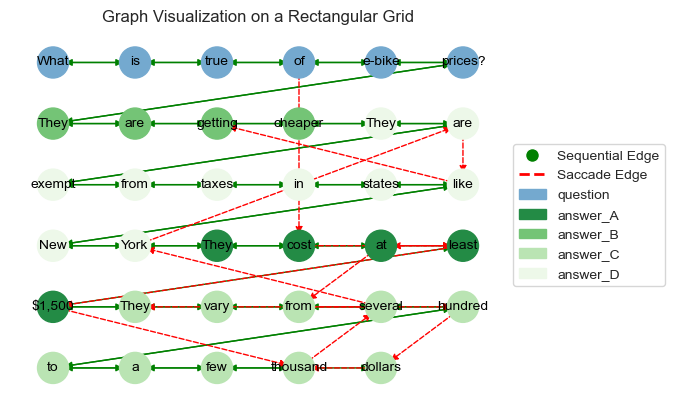

In [161]:
visualize_graph(graph)